In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def _get_cuda_autotune_config():
    configs = []
    for num_warps, num_stages in [
        (4, 2),
        (4, 3),
        (4, 4),
        (8, 2),
        (8, 3),
    ]:
        for BLOCK_SIZE_M in [32, 64, 128]:#, 128]:
            for BLOCK_SIZE_N in [32, 64, 128]:#[64, 128]:
                for BLOCK_SIZE_K in [16, 32]:#[16, 32]:
                    configs.append(
                        triton.Config(
                            {
                                "GROUP_SIZE_M" : 8,
                                "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                            }, 
                            num_warps=num_warps,
                            num_stages=num_stages, 
                        ),
                    )                        
    return configs


In [3]:
x = torch.arange(0, 16, dtype=torch.int8)

def torch_to_mxfp4(x):
    s = (x & 0x8) != 0
    e = (x & 0x6) >> 1
    m  = (x & 0x1)
    v = torch.where(e!=0, (1 << (e - 1)) * (1 + 0.5 * m), 0.5 * m)
    return torch.where(s, -v, v)

print(x)
torch_to_mxfp4(x)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=torch.int8)


tensor([ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  3.0000,  4.0000,  6.0000,
        -0.0000, -0.5000, -1.0000, -1.5000, -2.0000, -3.0000, -4.0000, -6.0000])

In [4]:
@triton.jit
def to_int4(v):
    return v - 0x8


@triton.jit
def to_mxint4(v):
    sign = (v & 0x8) != 0
    mag  = (v & 0x7)
    return tl.where(sign, -mag, mag)


@triton.jit
def to_mxfp4(x):
    s = (x & 0x8) != 0
    e = (x & 0x6) >> 1
    m  = (x & 0x1)
    v = tl.where(e!=0, (1 << (e - 1)) * (1 + 0.5 * m), 0.5 * m)
    return tl.where(s, -v, v)

@triton.jit
def mxfp4_lut(val):
    return tl.where(
        (val & 0b1000) == 8,
        tl.where(
            (val & 0b0100) == 4,
            tl.where(
                (val & 0b0010) == 2,
                tl.where((val & 0b0001) == 1, -6.0, -4.0),
                tl.where((val & 0b0001) == 1, -3.0, -2.0)
            ),
            tl.where(
                (val & 0b0010) == 2,
                tl.where((val & 0b0001) == 1, -1.5, -1.0),
                tl.where((val & 0b0001) == 1, -0.5, -0.0)
            )
        ),
        tl.where(
            (val & 0b0100) == 4,
            tl.where(
                (val & 0b0010) == 2,
                tl.where((val & 0b0001) == 1, 6.0, 4.0),
                tl.where((val & 0b0001) == 1, 3.0, 2.0)
            ),
            tl.where(
                (val & 0b0010) == 2,
                tl.where((val & 0b0001) == 1, 1.5, 1.0),
                tl.where((val & 0b0001) == 1, 0.5, 0.0)
            )
        )
    )

@triton.autotune(
    # configs=_get_cuda_autotune_config(),
    configs=[
        triton.Config(
            {
                "GROUP_SIZE_M" : 8,
                "BLOCK_SIZE_M" : 64,
                "BLOCK_SIZE_N" : 128,
                "BLOCK_SIZE_K" : 16,
            }, 
            num_warps=4,
            num_stages=2, 
        )
    ],
    key=[],
)
@triton.jit
def matmul_trellis_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,  #
        # Matrix dimensions
        M, K, N,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. stride_am is how much to increase a_ptr
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, 
        BLOCK_SIZE_K: tl.constexpr,  #
        BLOCK_SIZE_N: tl.constexpr, 
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # pid = tl.program_id(axis=0)
    # grid_n = tl.cdiv(N, BLOCK_SIZE_N)
    # pid_m = pid // grid_n
    # pid_n = pid % grid_n


    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # Add some integer bound assumptions.
    # This helps to guide integer analysis in the backend to optimize
    # load/store offset address calculation
    tl.assume(N % BLOCK_SIZE_N == 0)
    tl.assume(K % BLOCK_SIZE_K == 0)

    tl.assume(N >= BLOCK_SIZE_N)
    tl.assume(K >= BLOCK_SIZE_K)


    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % N
    offs_ak = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_ak[None, :] * stride_ak)


    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)

    pos_bn_low = tl.arange(0, (BLOCK_SIZE_N * 4))
    offs_bn_low = (pid_n * (BLOCK_SIZE_N * 4) + pos_bn_low) % (N * 4)

    pos_bn_high = tl.arange(1, 1 + (BLOCK_SIZE_N * 4))
    pos_bn_high = tl.where(pos_bn_high % 64 == 0, pos_bn_high - 64, pos_bn_high)
    offs_bn_high = (pid_n * (BLOCK_SIZE_N * 4) + pos_bn_high) % (N * 4)
        
    b_ptrs_low = b_ptr + (offs_bk[:, None] * stride_bk + offs_bn_low[None, :] * stride_bn)
    b_ptrs_high = b_ptr + (offs_bk[:, None] * stride_bk + offs_bn_high[None, :] * stride_bn)
    
    shifter = tl.arange(0, 4) * 4

    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_ak[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        bits_low = tl.load(b_ptrs_low) #, mask=offs_bk[:, None] < K // 16 - k * BLOCK_SIZE_K // 16, other=0.0)#.reshape(BLOCK_SIZE_K // 16, 64, BLOCK_SIZE_N // 16))        
        bits_high = tl.load(b_ptrs_high) #, mask=offs_bk[:, None] < K // 16 - k * BLOCK_SIZE_K // 16, other=0.0)#.reshape(BLOCK_SIZE_K // 16, 64, BLOCK_SIZE_N // 16)

        codes = bits_low.to(tl.uint16) | (bits_high.to(tl.uint16) << 8)
        codes = ((codes.to(tl.uint32) * 34038481) >> 9).to(tl.uint16)

        bits = (codes[:, :, None] >> shifter[None, None, :]) & 0xF
        
        # w = to_int4(bits)
        # w = to_mxint4(bits)
        # w = to_mxfp4(bits)
        w = mxfp4_lut(bits)

        w = tl.reshape(w, BLOCK_SIZE_K, BLOCK_SIZE_N).to(tl.float16)

        accumulator = tl.dot(a, w, accumulator, out_dtype=accumulator_dtype)
        
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs_high += (BLOCK_SIZE_K // 16) * stride_bk
        b_ptrs_low += (BLOCK_SIZE_K // 16) * stride_bk


    c = accumulator.to(tl.float16)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def trellis_matmul_triton(a, b_compressed):
    b_compressed = b_compressed.reshape(b_compressed.shape[0], -1)
    
    assert a.shape[1] == b_compressed.shape[0] * 16, "Incompatible dimensions"
    assert b_compressed.is_contiguous(), "Matrix B_compressed must be contiguous"

    M, K = a.shape
    N = b_compressed.shape[-1] // 4

    # Init out ptr
    c = torch.empty((M, N), device=b_compressed.device, dtype=torch.float16)

    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]), )

    matmul_trellis_kernel[grid](
        a, b_compressed, c,
        M, K, N,
        a.stride(0), 
        a.stride(1),
        b_compressed.stride(0), 
        b_compressed.stride(1),
        c.stride(0), 
        c.stride(1),
    )
    return c


In [5]:
def decode_uint16_to_int4_python(bits):
    bits = bits.to(torch.int32)
    val0 = (bits >> 12) & 0xF
    val1 = (bits >> 8) & 0xF
    val2 = (bits >> 4) & 0xF
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    sign2 = (val2 & 0x8) != 0
    sign3 = (val3 & 0x8) != 0
    
    dtype = torch.int8

    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    mag2 = (val2 & 0x7).to(dtype)
    mag3 = (val3 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)
    w2 = torch.where(sign2, -mag2, mag2)
    w3 = torch.where(sign3, -mag3, mag3)

    return torch.stack([w0, w1, w2, w3], dim=-1)


#torch.compile
def permute_16bits(x):
    x = x.to(torch.int32) * 34038481
    x = (x >> 9) # & 0xFFFF
    return x.to(torch.uint16)


#@torch.compile()
def decode_trellis_python(bits):
    M, N = bits.shape[0], bits.shape[1]
    
    even_codes = bits.view(torch.uint16)
    odd_codes = bits.roll(shifts=-1, dims=-1).view(torch.uint16)

    codes = torch.stack([even_codes, odd_codes], dim=-1).reshape(M, N, 64)
    
    bits = permute_16bits(codes)
    decoded = decode_uint16_to_int4_python(bits)

    return (
        decoded
        .reshape(M, N, 16, 16)      # Разворачиваем в 4D: (N, M, 16, 16)
        .permute(0, 2, 1, 3)        # Меняем оси → (N, 16, M, 16)
        .reshape(M * 16, N * 16)    # Сшиваем в один большой 2D тензор
    )



def test_2x2():
    BLOCKS = [2, 2]
    x_compressed = torch.randint(0, 255, (BLOCKS[0], BLOCKS[1], 64), dtype=torch.uint8, device="cuda")
    x_decompressed = decode_trellis_python(x_compressed)
    x_compressed_00 = x_compressed[0, 0][None, None, :]
    x_decompressed_00 = decode_trellis_python(x_compressed_00)
    assert torch.all(x_decompressed_00 == x_decompressed[:16, :16])

    x_compressed_01 = x_compressed[0, 1][None, None, :]
    x_decompressed_01 = decode_trellis_python(x_compressed_01)
    assert torch.all(x_decompressed_01 == x_decompressed[:16, 16:32])

    x_compressed_10 = x_compressed[1, 0][None, None, :]
    x_decompressed_10 = decode_trellis_python(x_compressed_10)
    assert torch.all(x_decompressed_10 == x_decompressed[16:32, :16])

    x_compressed_11 = x_compressed[1, 1][None, None, :]
    x_decompressed_11 = decode_trellis_python(x_compressed_11)
    assert torch.all(x_decompressed_11 == x_decompressed[16:32, 16:32])
    print("Test 2x2 passed!")

#test_2x2()

#@torch.compile
def trellis_matmul_torch(y, x_compressed):
    x_decompressed = decode_trellis_python(x_compressed)
    return y @ x_decompressed.to(torch.float16)
    

# torch.manual_seed(0)
# M, K, N = 3 * (1024,)
# WEIGHT_BLOCKS = [K // 16, N // 16]
# x_compressed = torch.randint(-128, 128, (WEIGHT_BLOCKS[0], WEIGHT_BLOCKS[1], 64), dtype=torch.int8, device="cuda")
# # #x_decompressed = decode_trellis_python(x_compressed)
# y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)**0.5

# # o1 = trellis_matmul_torch(y, x_compressed)

# # # from trellis_M_16_16 import trellis_matmul_triton
# o2 = trellis_matmul_triton(y, x_compressed)
# print(matmul_trellis_kernel.best_config)

# # assert torch.all(torch.isclose(o1, o2))


matmul-performance:
        M       K       N  triton_trellis
0   512.0   512.0   512.0        1.242757
1  1024.0  1024.0  1024.0        2.153133
2  2048.0  2048.0  2048.0        2.040609
3  4096.0  4096.0  4096.0        1.846357


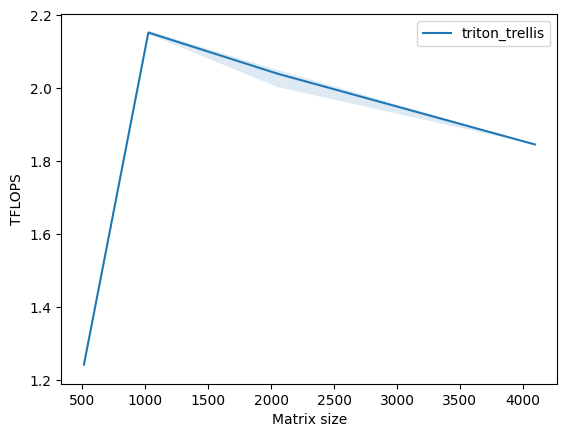

In [6]:
BS = 1
sizes = [512, 1024, 2048, 4096] #, 8192]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "K", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[(BS * size, size, size) for size in sizes],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=[
            # "torch_fp16", 
            "triton_trellis"
        ],  # Label name for the lines
        line_names=[
            # "torch_fp16", 
            "triton_trellis"
        ],  # Line styles
        # line_vals=["triton_trellis"],  # Label name for the lines
        # line_names=["triton_trellis"],  # Line styles
        #styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))

@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    # a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    # b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    y = torch.randn(M, K, dtype=torch.float16, device="cuda")
    x_compressed = torch.randint(0, 255, (K // 16, N // 16, 64), dtype=torch.uint8, device="cuda")
    x_decompressed = decode_trellis_python(x_compressed).to(torch.float16)

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y, x_decompressed), quantiles=quantiles)
    if provider == "torch_trellis":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: trellis_matmul_torch(y, x_compressed), quantiles=quantiles)
    if provider == 'triton_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: trellis_matmul_triton(y, x_compressed), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=False, print_data=True)

In [7]:
# matmul-performance:
#         M       K       N  triton_trellis
# 0   512.0   512.0   512.0        1.401137
# 1  1024.0  1024.0  1024.0        2.455682
# 2  2048.0  2048.0  2048.0        2.326937
# 3  4096.0  4096.0  4096.0        2.169293

In [8]:
# matmul-performance:
#         M       K       N  triton_trellis
# 0   512.0   512.0   512.0        1.352565
# 1  1024.0  1024.0  1024.0        2.353376
# 2  2048.0  2048.0  2048.0        2.211019
# 3  4096.0  4096.0  4096.0        2.119741

In [9]:
# matmul-performance:
#         M       K       N  triton_trellis
# 0   512.0   512.0   512.0        1.262014
# 1  1024.0  1024.0  1024.0        1.660925
# 2  2048.0  2048.0  2048.0        2.069445
# 3  4096.0  4096.0  4096.0        1.949693


In [ ]:
# matmul-performance:
#         M       K       N  triton_trellis
# 0   512.0   512.0   512.0        1.242757
# 1  1024.0  1024.0  1024.0        2.153133
# 2  2048.0  2048.0  2048.0        2.040609
# 3  4096.0  4096.0  4096.0        1.846357